In [1]:
!pip3 install opencv-python dlib face_recognition numpy scikit-learn mtcnn keras-facenet torch joblib

In [2]:
import os
import cv2
from mtcnn import MTCNN
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
from keras_facenet import FaceNet
import logging
import torch

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
# Suppress TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # '0' = all logs, '1' = filter INFO, '2' = filter WARNING, '3' = filter ERROR

# Set logging level to ERROR to suppress lower level messages
logging.basicConfig(level=logging.ERROR)

# Alternatively set TensorFlow logging verbosity directly
tf.get_logger().setLevel('ERROR')

logging.getLogger('tensorflow').setLevel(logging.ERROR)

logging.getLogger('mtcnn').setLevel(logging.ERROR)

In [6]:
# video_path = "./data/recordings/surya.mov"

# Path containing all the the videos
video_path = "./data/recordings/"
videos = os.listdir(video_path)
videos

frame_output_folder = "./data/frames/"
augment_output_folder = "./data/augmented_frames/"

In [22]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

In [29]:
# Initialize MTCNN detector
detector = MTCNN()
embedder = FaceNet()

In [32]:
def convert_video_to_frames(label_name, video_path, output_dir,max_frames=200, min_face_width=100, min_face_height=100):
    video_capture = cv2.VideoCapture(video_path)
    
    total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
   
    # Set frame sampling rate dynamically based on total number of frames
    if total_frames <= max_frames:
        frame_interval = 1  # No need to skip frames if video is short
    else:
        frame_interval = total_frames // max_frames  # Adjust frame sampling rate
    
    
    frame_count = 0
    extracted_frames = 0
    face_count = 0
    while True:
        
        # Read a single frame from the video
        ret, frame = video_capture.read()
        if not ret or extracted_frames >= max_frames:
            break  # Stop if video ends or we have reached 
        
        
        frame_count += 1
        # Process every nth frame (e.g., every 10th frame)
        if frame_count % frame_interval == 0:
            # Convert the frame from BGR (OpenCV format) to RGB (for face_recognition)
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Find all face locations in the current frame
            face_detections = detector.detect_faces(rgb_frame)

            for i, detection in enumerate(face_detections):
                x, y, w, h = detection["box"]

                if w < min_face_width or h < min_face_height:
                    continue

                face_image = frame[y : y + h, x : x + w]
                face_image_resized = cv2.resize(face_image, (160, 160))
                # Save the cropped face image
                face_file_name = f"{label_name}_aug_{i}.jpg"
                face_path = os.path.join(output_dir, face_file_name)
                cv2.imwrite(face_path, face_image_resized)
                face_count += 1
            
            extracted_frames += 1  # Only count frames with detected faces
            if frame_count % 10 == 0:
                print(f"Processed {frame_count}/{total_frames} frames, extracted {extracted_frames}/{max_frames} so far...")

    # Release the video capture object
    video_capture.release()
    print(f"Completed processing {frame_count} frames, extracted {extracted_frames} frames with {face_count} faces.")

In [33]:
def augment_images(label, input_dir, output_dir):
    final_output_dir = output_dir + "/" + label + "/"

    if not os.path.exists(final_output_dir):
        os.makedirs(final_output_dir)

    total_images = len(os.listdir(input_dir))
    max_augmentations = 5 if total_images < 100 else 2  # Reduce augmentations if too many images

    for idx, img_name in enumerate(os.listdir(input_dir), 1):
        img_path = os.path.join(input_dir, img_name)
        img = cv2.imread(img_path)

        if img is not None:
            # Ensure the image is in RGB format
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Reshape to a 4D tensor for the ImageDataGenerator
            img = img.reshape((1,) + img_rgb.shape)

            i = 0
            for batch in datagen.flow(
                img,
                batch_size=1,
                save_to_dir=final_output_dir,
                save_prefix="aug",
                save_format="jpg",
            ):
                i += 1
                if i >= max_augmentations:  # Generate 5 augmented images per original image
                    break
        print(f"Augmented {idx}/{total_images} images")
        
    print(f"Completed augmentation of {total_images} images.")                

In [ ]:
for _vid in videos:
    label_name = _vid.split(".")[0]
    student_video_path = video_path + _vid

    frame_output_dir = frame_output_folder + label_name
    if not os.path.exists(frame_output_dir):
        os.makedirs(frame_output_dir)
    convert_video_to_frames(label_name, student_video_path, frame_output_dir)

In [ ]:
for _vid in videos:

    if not _vid.endswith(".mov"):
        continue
    
    label_name = _vid.split(".")[0]
    student_video_path = video_path + _vid

    frame_output_dir = frame_output_folder + label_name
    augment_output_dir = augment_output_folder
    if not os.path.exists(augment_output_dir):
        os.makedirs(augment_output_dir)

    augment_images(label_name, frame_output_dir, augment_output_dir)

In [35]:
# Load dataset
def load_images_from_folder(
    folder, embeddings_file="./model/face_embeddings.npy", labels_file="./model/face_labels.npy"
):

    # Load existing embeddings and labels if they exist
    if os.path.exists(embeddings_file) and os.path.exists(labels_file):
        embeddings = list(np.load(embeddings_file, allow_pickle=True))
        labels = list(np.load(labels_file, allow_pickle=True))
        print(f"Loaded {len(labels)} existing faces.")
    else:
        embeddings = []
        labels = []
        print("No existing embeddings found. Starting fresh.")

    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder, filename)

            image = cv2.imread(image_path)
            rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            detections = detector.detect_faces(rgb_image)

            for detection in detections:
                x, y, width, height = detection["box"]
                face = rgb_image[y : y + height, x : x + width]
                # Use FaceNet to compute face embeddings
                face_embedding = embedder.embeddings([face])

                # Append the face embeddings
                embeddings.append(face_embedding[0])

                # Assume filename corresponds to the label (e.g., student name)
                label = folder.split("/")[-1]
                labels.append(label)

    return embeddings, labels

In [46]:
framed_images = os.listdir(frame_output_folder)
print(framed_images)

['shyam', '.DS_Store', 'surya', 'pugal', 'lakshmi']


In [47]:
agumented_images = os.listdir(augment_output_folder)
agumented_images

['shyam', 'surya', 'pugal', 'lakshmi']

In [ ]:
for _img in agumented_images:
  label_name = _img.split(".")[0]
  augmented_frame_output_dir = augment_output_folder + label_name
  
  print(f"Processing {label_name}...")
  
  face_embeddings, face_labels = load_images_from_folder(augmented_frame_output_dir)
  np.save("./model/face_embeddings.npy", face_embeddings)
  np.save("./model/face_labels.npy", face_labels)

In [9]:
embeddings = (np.load("./model/face_embeddings.npy", allow_pickle=True))
labels = (np.load("./model/face_labels.npy", allow_pickle=True))

In [10]:
embeddings.shape, labels.shape

((792, 512), (792,))

# Train - Test Split

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [12]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)


X_train, X_test, y_train, y_test = train_test_split(embeddings, labels_encoded, test_size=0.2, random_state=42)

# Classifier: SVC

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [17]:
svm_classifier = SVC(kernel="linear", probability=True)
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

In [18]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(
    "Classification Report: \n",
    classification_report(y_test, y_pred, target_names=label_encoder.classes_),
)

Accuracy: 100.00%
Classification Report: 
               precision    recall  f1-score   support

     lakshmi       1.00      1.00      1.00        44
       pugal       1.00      1.00      1.00        43
       shyam       1.00      1.00      1.00        30
       surya       1.00      1.00      1.00        42

    accuracy                           1.00       159
   macro avg       1.00      1.00      1.00       159
weighted avg       1.00      1.00      1.00       159



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save the Model

In [22]:
import joblib

# Save the trained model
joblib.dump(svm_classifier, './model/face_classifier.pkl')

# Save the label encoder for future decoding
joblib.dump(label_encoder, './model/label_encoder.pkl')

['./model/label_encoder.pkl']

# load the Model and Label encoder

In [24]:
import joblib

svm_classifier = joblib.load("./model/face_classifier.pkl")
label_encoder = joblib.load("./model/label_encoder.pkl")

In [25]:
def classify_faces_in_image(image_path, embedder, detector, classifier, label_encoder, img_size=(160, 160)):
  image = cv2.imread(image_path)
  rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  
  detections = detector.detect_faces(rgb_image)
  
  for i, detection in enumerate(detections):
    x,y,w,h = detection['box']
    face = rgb_image[ y:y+h, x:x+w ]
    
    face_resized = cv2.resize(face, img_size)
    face_embedding = embedder.embeddings([face_resized])
    
    predicted_label_encoded = classifier.predict(face_embedding)
    predicted_label = label_encoder.inverse_transform(predicted_label_encoded)
    
    print(f"Face {i + 1}: Predicted label: {predicted_label[0]}")

In [26]:
def show_faces_with_mtcnn(image_path):
    detector = MTCNN()
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Convert BGR to RGB
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect faces
    detections = detector.detect_faces(rgb_image)

    if len(detections) == 0:
        print("No faces detected.")
        return

    # Draw rectangles around each face
    for detection in detections:
        x, y, width, height = detection["box"]
        cv2.rectangle(image, (x, y), (x + width, y + height), (0, 255, 0), 2)

    # Show the image with faces highlighted
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Detected {len(detections)} face(s)")
    plt.show()

In [27]:
test_image_1_path = "./data/test/test_1.jpeg"
test_image_2_path = "./data/test/test_2.jpeg"
test_image_3_path = "./data/test/test_3.jpeg"
test_image_4_path = "./data/test/test_4.jpeg"
test_image_5_path = "./data/test/test_5.jpeg"
test_image_6_path = "./data/test/test_6.jpeg"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


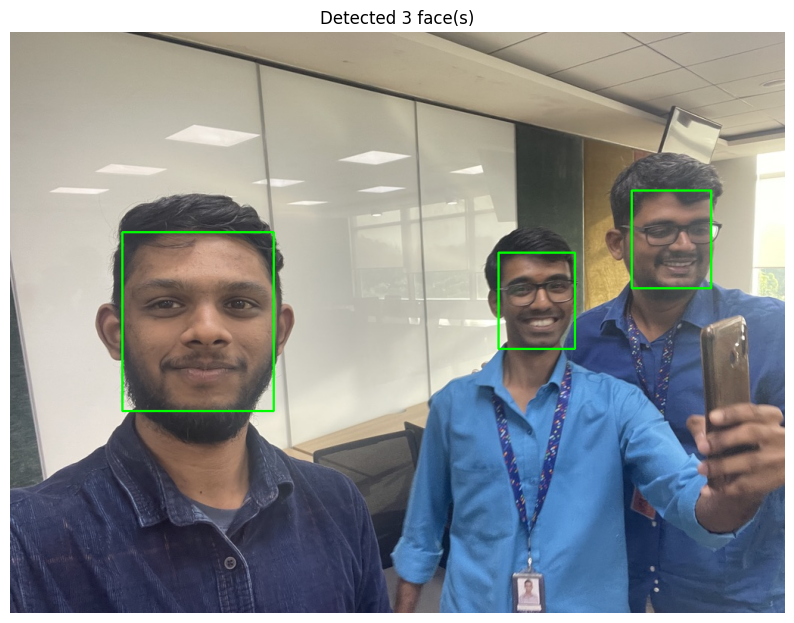

In [34]:
# using mtcnn face detector
# show_faces_with_mtcnn(test_image_1_path)
# show_faces_with_mtcnn(test_image_2_path)
show_faces_with_mtcnn(test_image_3_path)
# show_faces_with_mtcnn(test_image_4_path)
# show_faces_with_mtcnn(test_image_5_path)
# show_faces_with_mtcnn(test_image_6_path)

In [35]:
classify_faces_in_image(test_image_3_path, embedder, detector, svm_classifier, label_encoder)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Face 1: Predicted label: surya
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Face 2: Predicted label: shyam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Face 3: Predicted label: shyam
